<a href="https://colab.research.google.com/github/AumkarMali/ACR-Robotic-Turk/blob/main/Copy_of_F24_Tron_Days_Recreating_a_Piano_Note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recreating a Piano Note

In the previous section, you learned how different sounds can be created by manipulating sine waves. Synthesizers manipulate sine waves to closely approximate a variety of different sounds. In this section, you will decompose a piano note into sine waves and recreate it digitally.

First obtain the sound of a piano note. There are 2 options.

**Option 1**: Record a piano sample using Audacity.
1. Go to the piano in one of the following locations:
  - E6 3rd floor corridor
  - E7 6th floor main area
2. From the toolbar in Audacity, select ‘Tracks’ > ‘Add New’ > ‘Stereo Track’.
3. Record a piano note – press R to start recording and space to stop.
4. Select your recorded sample and click on the 'File' tab at the top. Click 'Export' and select 'Export as WAV'. Give the file a memorable name and save it to your computer.

**Option 2**: Use piano note provided.
1. Download the provided piano notes.

Next, upload your piano sound to the Colab by selecting the '**File**' icon on the left side. **Right click** and select '**Upload**' and select your piano sound.


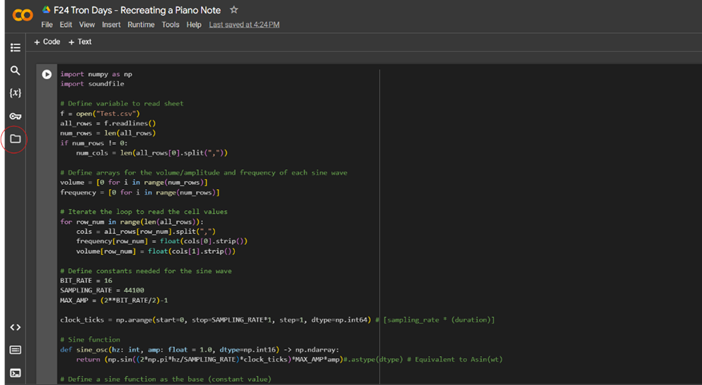

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# Frequency Analysis

A **frequency plot** shows the amplitudes of all the component sine waves that make up our piano sound sample.

First, import the nesscary libraries. Run the cell below.

In [ ]:
!pip install audiosegment
import audiosegment
import numpy as np
import matplotlib.pyplot as plt
import wave, sys
import pandas
import math
import soundfile as sf

Then, we must check to see if the audio file is mono or stereo.

A **mono** sound has just one audio channel whereas a **stereo** sound has two, a 'left' and 'right' channel.

If it is stereo, it must be converted to mono before being graphed. This function will return a new audio file that is confirmed to be mono.

Run the cell below.

In [ ]:
def mono_check(file):
  # Read the audio file (assuming it might have multiple channels)
  data, sample_rate = sf.read(file)

  # Check if the data is multi-dimensional (has multiple channels)
  if data.ndim > 1:
      # Convert to mono by averaging the channels
      mono_data = np.mean(data, axis=1)
  else:
      # The file is already mono
      mono_data = data

  # Save the mono audio to a new file
  sf.write('mono_'+ file, mono_data, sample_rate)


# Function to save waveform to a WAV file
def save_waveform_to_wav(waveform, filename, sampling_rate):
    waveform_int16 = np.int16((waveform / np.max(np.abs(waveform))) * 32767)
    with wave.open(filename, 'w') as wav_file:
        wav_file.setparams((1, 2, sampling_rate, len(waveform_int16), "NONE", "not compressed"))
        wav_file.writeframes(waveform_int16.tobytes())



# Frequncy Plot

The **freq()** function takes in a .wav file and plots its frequency plot. First it checks for a stereo sound, then uses a Fourier transform to obtain all the individual sine wave component frequencies and their respective amplitdues (dB). Finally, we plot the data.

Run the cell below.

In [ ]:
from scipy.fft import *
#from scipy.io import wavfile

def freq(file):
    # Open the file with soundfile to handle both mono and stereo files
    data, sample_rate = sf.read('mono_' + file)

    # Fourier Transform
    N = len(data)  # Total number of samples
    yf = rfft(data)  # FFT of the audio data
    xf = rfftfreq(N, 1 / sample_rate)  # Frequency bins

    # Plot the frequency spectrum
    plt.figure(figsize=(15, 5))
    plt.plot(xf, np.abs(yf))  # Plot amplitude vs frequency
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title('Frequency Spectrum (Linear Scale)')
    plt.show()
    print()

    plt.show()

Let's hear the piano sound. Replace 'note.wav' with your piano sound file. Run the cell below.

In [ ]:
from IPython.display import Audio, display

display(Audio('note.wav', autoplay=True))

Let's see the frequency plot the piano sound now. Replace 'note.wav' with your piano sound.

In [ ]:
mono_check('note.wav')
freq('note.wav')

# Summing Component Sine Waves

Now let's extract the frequncy and amplitude data from the frequency spectrum and use it to recreate our piano note.

The **freq_data()** function below takes in a .wav file and performs a Fourier transform on it. It returns the frequncy and amplitude data in a Pandas dataframe -- think of it like a table -- which is sorted from highest to lowest amplitude.

In [ ]:
import soundfile as sf
from scipy.fft import *
import pandas as pd
from scipy.io import wavfile

def freq_data(file):
  # Open the file with soundfile to handle both mono and stereo files
    data, sample_rate = sf.read('mono_' + file)

    # Fourier Transform
    N = len(data)  # Total number of samples
    yf = rfft(data)  # FFT of the audio data
    xf = rfftfreq(N, 1 / sample_rate)  # Frequency bins

    # Store frequency and amplitude data in a Pandas Dataframe
    freq = pd.Series(xf).rename("Frequency")
    amp = pd.Series(np.abs(yf)).rename("Amplitude")

    # Order by descending amplitudes
    df = pd.concat([freq,amp], axis=1).sort_values(by='Amplitude', ascending=False)

    print(df)

    return df

Now let's apply it to our piano sound. Replace 'note.wav' with your piano sound.

In [ ]:
mono_check("note.wav")
freq_amp_data = freq_data("note.wav")

Next, generate the appropriate sine waves and sum them together to create our approximation.

The **sine_wave()** function generates a sine wave based on the frequency and amplitdue provided.

The **sine_approx()** function takes in a Pandas dataframe then generates and sums the sine waves to recreate our piano note. It then saves the recreation to a .wav file titled "sine_approx.wav".


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import wave
import struct
import pandas as pd

# Function to generate a single sine wave
def sine_wave(freq, amplitude, phase, duration, sampling_rate):
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    return amplitude * np.sin(2 * np.pi * freq * t + phase), t

# Function to create our approximation
def sine_approx(df, num_harmonics):
  freq_list = pd.Series(df.Frequency).to_list()
  amp_list = pd.Series(df.Amplitude).to_list()

  sine_approx_wave = sine_wave(0,0,0,2,44100)

  # Loops through our list of frequencies and amplitudes and sums their associated sine waves together.
  for i in range(0, num_harmonics):
    f=freq_list[i]
    a=amp_list[i]
    component,t = sine_wave(f, a, 0, 2, 44100)
    sine_approx_wave += component

  # Save as .wav file
  save_waveform_to_wav(sine_approx_wave, "sine_approx.wav", 44100)

Let's hear our recreation.

The **number_of_components** variable controls how many sine waves we use in our recreation. Initially we have it set to 1000.

Run the cell below.

In [ ]:
from IPython.display import Audio, display

# Number of sine waves used in approximation.
number_of_components = 1000

sine_approx(freq_amp_data, number_of_components)

display(Audio('sine_approx.wav', autoplay=True))

***Are there any differences between the original note and the recreated note? Is it possible to discern the original note through the recreated note’s sound? ***


Run the cell containing the **sine_approx() function** but change ***'sine_approx.wav'*** to ***'sine_approx_10.wav'***. In the code cell above, change number_of_components to equal 10 and change the **display()** function to take in ***'sine_approx_10.wav'*** and run the cell.


**Compare this note to our first recreation attempt (sine_approx.wav).  Is our first recreation attempt more similar to the original note than the second? Discuss why or why not.**

Now, complete a third attempt using **only one frequency**. Change the file names in the 2 above cells to be ***'sine_approx_1.wav'***. Change number_of_components to equal 1. Run both cells.


Look up the frequency of the recorded note and compare it with the frequency of
our third attempt. Ideally, there should not be much discrepancy between the values.


We can convert our frequency-amplitude data table into a .csv file. Run the cell below. Download ***'freq_amp_data.csv'*** (file tab on the left) and look through and try to spot any harmonics of this main tone (using the knowledge you gained about harmonics from Manipulating Sound Waves).

In [ ]:
freq_amp_data.to_csv("freq_amp_data.csv")

# The .csv file should appear in the Colab files.

Let's see how the frequncy plots of our 3 recreations compare. Run the cell below.

In [ ]:
from IPython.display import Audio, display

# Our first recreation: 1000 sine wave components
display(Audio('sine_approx.wav', autoplay=False))
freq('sine_approx.wav')

# Our second recreation: 10 sine wave components
display(Audio('sine_approx_10.wav', autoplay=False))
freq('sine_approx_10.wav')

# Our third recreation: 1 sine wave component
display(Audio('sine_approx_1.wav', autoplay=False))
freq('sine_approx_1.wav')

Play ***sine_approx.wav*** to the teaching team to proceed to the next activity.